In [29]:
from scipy.io import loadmat
import h5py
from matplotlib import pyplot as plt
import numpy as np
from scipy.interpolate import griddata
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.io import loadmat
from scipy.interpolate import griddata

In [25]:

data_vort=loadmat('cylinder_nektar_t0_vorticity.mat')
data=loadmat('cylinder_nektar_wake.mat')

In [41]:
def load_navier_stokes_mat(filepath, nx=200, ny=100):
    data = loadmat(filepath)
    X_star = data['X_star']        # N x 2
    U_star = data['U_star']        # N x 2 x T
    t_star = data['t'].squeeze()   # (T,)

    x = X_star[:,0]
    y = X_star[:,1]
    T = U_star.shape[2]

    # Uniform grid
    xg = np.linspace(x.min(), x.max(), nx)
    yg = np.linspace(y.min(), y.max(), ny)
    X, Y = np.meshgrid(xg, yg)
    dx = xg[1]-xg[0]
    dy = yg[1]-yg[0]

    vort_all = np.zeros((ny, nx, T))

    for k in range(T):
        u = U_star[:,0,k]
        v = U_star[:,1,k]

        U = griddata((x,y), u, (X,Y), method='cubic')
        V = griddata((x,y), v, (X,Y), method='cubic')

        dvdx = np.gradient(V, dx, axis=1)
        dudy = np.gradient(U, dy, axis=0)
        vort_all[:,:,k] = dvdx - dudy

    return {
        "X": X, "Y": Y,
        "t": t_star,
        "vorticity": vort_all
    }

data_dict=load_navier_stokes_mat('cylinder_nektar_wake.mat')


In [42]:
for k,v in data_dict.items():
    if isinstance(v, np.ndarray):
        print(f"{k}: {v.shape}, {v.dtype}")
    else:
        print(f"{k}: {type(v)}")

X: (100, 200), float64
Y: (100, 200), float64
t: (200,), float64
vorticity: (100, 200, 200), float64


In [48]:
data_dict['t']

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9,
       11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. ,
       12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. , 13.1,
       13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14. , 14.1, 14.2,
       14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15

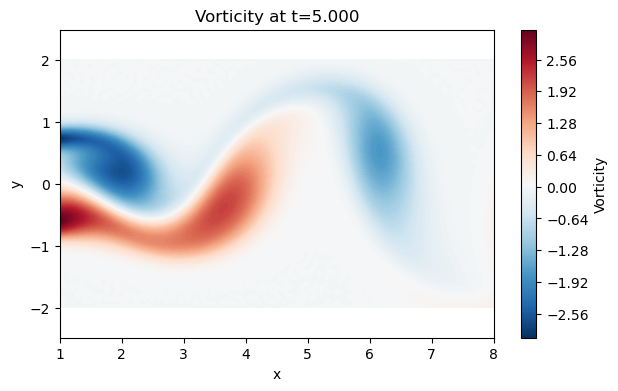

In [43]:
def plot_vorticity_snapshot(data_dict, frame, cmap="RdBu_r"):
    """
    Plot precomputed vorticity field at one time step.
    """
    X, Y, t, vort_all = data_dict["X"], data_dict["Y"], data_dict["t"], data_dict["vorticity"]
    omega = vort_all[:,:,frame]

    plt.figure(figsize=(7,4))
    plt.contourf(X, Y, omega, levels=200, cmap=cmap)
    plt.colorbar(label="Vorticity")
    plt.title(f"Vorticity at t={t[frame]:.3f}")
    plt.xlabel("x"); plt.ylabel("y")
    plt.axis("equal")
    plt.show()
plot_vorticity_snapshot(data_dict, frame=50)

In [44]:
def animate_vorticity(data_dict, interval=100, cmap="RdBu_r"):
    """
    Animate precomputed vorticity fields.
    """
    from matplotlib.colors import Normalize

    X, Y, t, vort_all = data_dict["X"], data_dict["Y"], data_dict["t"], data_dict["vorticity"]
    T = vort_all.shape[2]

    fig, ax = plt.subplots(figsize=(7,4))
    norm = Normalize(vmin=-np.nanmax(abs(vort_all)), vmax=np.nanmax(abs(vort_all)))
    quad = ax.pcolormesh(X, Y, vort_all[:,:,0], cmap=cmap, norm=norm, shading='auto')
    fig.colorbar(quad, ax=ax, label="Vorticity")
    ax.set_xlabel("x"); ax.set_ylabel("y")
    ax.set_title(f"Vorticity, t={t[0]:.3f}")
    ax.set_aspect("equal")

    def update(frame):
        quad.set_array(vort_all[:,:,frame].ravel())
        ax.set_title(f"Vorticity, t={t[frame]:.3f}")
        return [quad]

    ani = animation.FuncAnimation(fig, update, frames=T, interval=interval, blit=False)
    plt.show()
    return ani

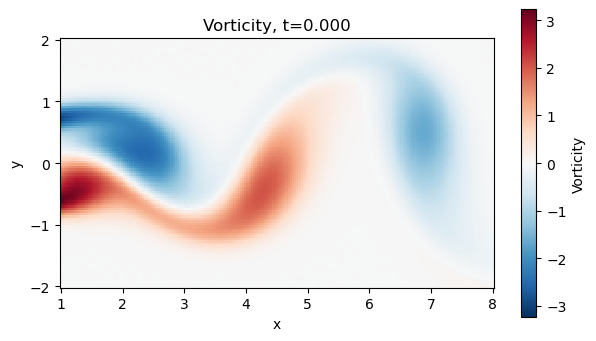

/home/nilay/miniforge3/envs/pdejax/lib/python3.11/site-packages/matplotlib/animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [45]:
ani = animate_vorticity(data_dict, interval=80)

In [46]:
ani.save("vorticity.gif", writer="ffmpeg", dpi=150)  # optional save